<a href="https://colab.research.google.com/github/kadvance/Transformer-for-Time-Series-Data-Anomaly-Detection/blob/main/03_TimeseriesTransformer_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  [ LG전자_DIC ] 트랜스포머 기반 시계열 데이터 표상 학습

## STOC

## 강의 복습

강의자료 : 트랜스포머 기반 시계열 데이터 표상 학습

- Transformer는 Sequence를 입력으로 받아 sequenc를 출력하는 구조이므로, 시계열 과업에도 적용 가능
- 시계열 이상치 탐지 : 주어진 시계열 데이터에 대해, 과거 데이터를 기반으로 t 시점에서의 abnormal 여부 예측

<img src="https://github.com/hwk0702/LGE_Transformer4TS/blob/main/image/AD01.png?raw=1" width="900">

## 실습 요약
1. 본 실습에서는 Transformer 기반의 이상치 탐지 모델인 STOC를 활용하여 시계열 이상탐지 모델을 구축합니다
2. 학습된 모델을 활용하여 평가를 진행합니다
3. 해당 모델에 대한 전체적인 구조는 강의자료 66 page에서 확인하실 수 있습니다

[Kim, Jina, Hyeongwon Kang, and Pilsung Kang. "Time-series anomaly detection with stacked Transformer representations and 1D convolutional network." Engineering Applications of Artificial Intelligence 120 (2023): 105964.](https://www.sciencedirect.com/science/article/pii/S0952197623001483?dgcid=author)

<img src="https://github.com/hwk0702/LGE_Transformer4TS/blob/main/image/STOC01.png?raw=1" width="700">

----

### STEP 0. 환경 구축하기
* 필요한 library들을 import 합니다

In [ ]:
# github에서 데이터 불러오기
# !git clone https://github.com/hwk0702/LGE_Transformer4TS.git
%cd STOC

/tf/dsba/External_Lecture/2024/LGE_Transformer4TS/STOC


In [ ]:
#!pip install torch==1.11.0

In [ ]:
import os  # 운영 체제와 상호 작용하기 위한 모듈
import sys  # 시스템 관련 정보에 접근하기 위한 모듈
import json  # JSON 형식의 데이터를 다루기 위한 모듈
import time  # 시간과 관련된 함수를 제공하는 모듈
import random  # 난수 생성과 관련된 함수를 제공하는 모듈
import importlib  # 모듈을 동적으로 로드하기 위한 모듈
import numpy as np  # 다차원 배열과 연산을 다루는 모듈
import pandas as pd  # 데이터 조작 및 분석을 위한 모듈
from easydict import EasyDict  # 딕셔너리의 속성을 점 표기법으로 접근할 수 있도록 하는 모듈
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 모듈
from sklearn.preprocessing import MinMaxScaler  # 데이터 스케일링을 위한 모듈

import torch  # 딥러닝 라이브러리인 PyTorch를 사용하기 위한 모듈
import torch.backends.cudnn as cudnn  # CUDA 라이브러리를 사용하기 위한 모듈
import torch.nn as nn  # 신경망 모델을 생성하기 위한 모듈
from torch.utils.data import Dataset  # 데이터셋을 처리하기 위한 모듈

from sklearn.metrics import roc_auc_score, precision_recall_curve  # 성능 지표를 계산하기 위한 모듈

# from trainer import Trainer
from dataloader import make_matplt, get_dataloader  # 데이터로더 생성 함수 및 시각화 함수를 불러오기 위한 모듈

import warnings  # 경고 메시지를 관리하기 위한 모듈
warnings.filterwarnings("ignore")  # 경고 메시지를 무시하도록 설정

#check torch version & device
print ("Python version:[%s]."%(sys.version))
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device)) # device에 cuda:0가 프린트 된다면 GPU를 사용하는 상태입니다

Python version:[3.6.9 (default, Dec  8 2021, 21:08:43) 
[GCC 8.4.0]].
PyTorch version:[1.7.1].
device:[cuda:0].


In [ ]:
# set random seed

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

random_seed = 42
set_seed(random_seed)

### STEP 1. 모델 학습에 필요한 파라미터 선언하기

In [ ]:
args = EasyDict({
    # for dataloader
    'root_path':'../data/yahoo_S5/A2Benchmark/',
    'data_name':'synthetic_1.csv',
    'num_features':1,
    'make_plot':True,
    'test_ratio':0.6,
    'valid_ratio':0.1,
    'normal':True,
    'window_size':48,
    'batch_size':128,
    'slide_size':1,
    'forecast':True,
    'forecast_step':1,

    # for training
    'training':True,
    'checkpoint':'best',
    'cuda':True,
    'n_feature':1,
    'lr':0,
    'epochs':300,
    'step_size':5,
    'gamma':1.0,
    'version':0,

    # for gradient clipping
    'clip':False,
    'max_norm':1.0,

    # for early stopping
    'early_stopping':True,
    'patience':30,
    'save_list':False,
    'min_epoch':0,

    # for Transformer
    'feature_size':256,
    'num_layers':1,
    'dropout':0.1,
    'nhead':8,
    'activation':None,

    # for model
    'model':'STOC',
    'trend_learning':False,

    # for testing
    'eval_plot':True,
    'anomaly_plot':True,
    'shuffle':False,
    'pred_one':False,

    # for save
    'experiment_name':'STOC_test'
})

### STEP 2. 데이터 준비하기

금일 실습에서는 Yahoo S5 데이터를 활용하여 시계열 이상치 탐지를 진행합니다.
* 해당 데이터는 연구용 시계열 데이터로 실제 데이터가 아닌 합성 데이터들로 이루어짐
* 여러가지 데이터중 한가지 시계열 데이터를 가져와 학습 및 추론을 수행함
* 데이터셋 출처
    * https://webscope.sandbox.yahoo.com/catalog.php?datatype=s&did=70

In [ ]:
# 현재 데이터는 확인 용도

data = pd.read_csv('../data/yahoo_S5/A2Benchmark/synthetic_1.csv')

In [ ]:
data

,timestamp,value,is_anomaly
0,1416726000,13.894031,0
1,1416729600,33.578274,0
2,1416733200,88.933746,0
3,1416736800,125.389424,0
4,1416740400,152.962000,0
...,...,...,...
1416,1421823600,-141.419766,0
1417,1421827200,-139.657834,0
1418,1421830800,-70.550652,0
1419,1421834400,-16.857148,0


In [ ]:
# 데이터 분석
def make_df_matplt(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(30, 5))

    # ax.set_title(data_name)
    ax.set_xlabel('time')
    ax.set_ylabel('value')
    ax.plot(df.timestamp, df.value)
    for i, label in enumerate(df.is_anomaly):
        if label == 1:
           ax.axvline(x=df.timestamp[i], linewidth=0.5, color='#d62728')
    plt.show()

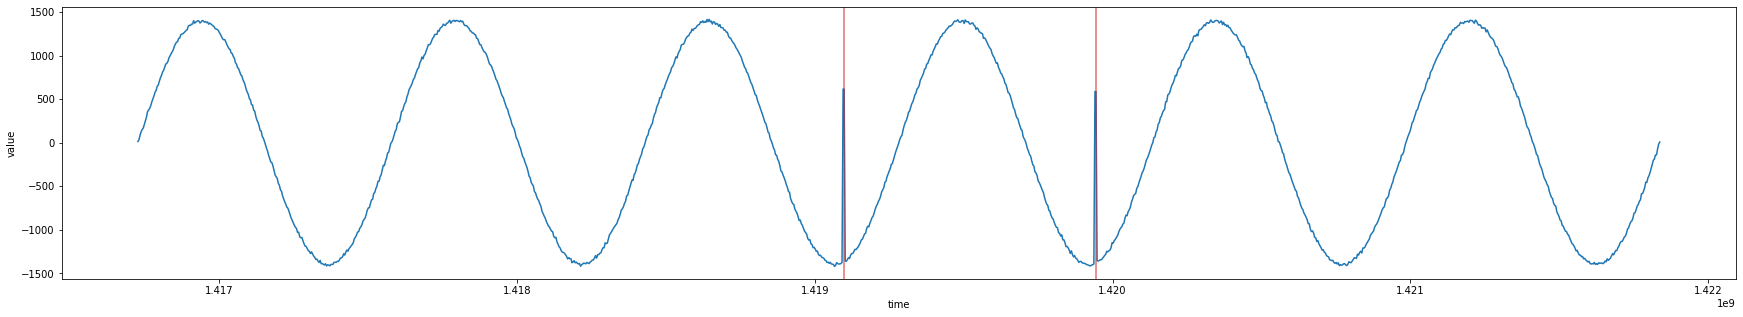

In [ ]:
make_df_matplt(data)

### STEP 3. 데이터 나누기

In [ ]:
test_len = int(args.test_ratio * data.shape[0])
train_len = int((1 - args.valid_ratio - args.test_ratio) * data.shape[0])

full = data.copy()
trn = data.iloc[:train_len, :].copy()
dev = data.iloc[train_len:-test_len, :].copy()
tst = data.iloc[-test_len:, ].copy()

full_len = len(full)
trn_len = len(trn)
dev_len = len(dev)
tst_len = len(tst)

### STEP 4. 데이터 전처리

In [ ]:
# StandardScaler 객체 생성
scaler = MinMaxScaler()

# 데이터를 표준화하기 위해 fit 및 transform 메서드 사용
trn["value"] = scaler.fit_transform(trn["value"].values.reshape(-1, 1))
dev["value"] = scaler.transform(dev["value"].values.reshape(-1, 1))
tst["value"] = scaler.transform(tst["value"].values.reshape(-1, 1))
full["value"] = scaler.transform(full["value"].values.reshape(-1, 1))

full.to_csv(
    f"{args.root_path}/normalized_{args.data_name[:-4]}_val_{args.valid_ratio}_tst_{args.test_ratio}.csv"
)

In [ ]:
trn

,timestamp,value,is_anomaly
0,1416726000,0.506967,0
1,1416729600,0.513934,0
2,1416733200,0.533526,0
3,1416736800,0.546429,0
4,1416740400,0.556188,0
...,...,...,...
421,1418241600,0.010606,0
422,1418245200,0.017357,0
423,1418248800,0.019705,0
424,1418252400,0.025009,0


### STEP 5. 데이터셋 구축 및 데이터로더 생성

In [ ]:
class BuildDataset(Dataset):
    """
    A class to make a dataset of Yahoo S5 dataset
    Yahoo dataset has columns of timestamp, value, and is_anomaly which is the anomaly label

    Args:
        # args에 root_path, data_name, window_size, slide_size 받아서 output으로 뱉기

        args (object): including settings for loading data and preprocessing
            self.data_name = 'real_1.csv' # dataset name
            self.root_path = '../yahoo_S5/A1Benchmark'
            self.window_size = 60

    """

    def __init__(self, data, args: object):

        self.window_size = args.window_size
        self.slide_size = args.slide_size
        self.forecast_step = args.forecast_step

        self.data = data.iloc[:, 1].values
        self.label = data.iloc[:, -1].values

        self.start_point = range(
            0, len(self.data) - self.window_size - self.forecast_step
        )

        # for forecasting
        self.forecast = args.forecast
        self.forecast_step = args.forecast_step

    def __len__(self):
        return len(self.start_point)

    def __getitem__(self, idx):
        return torch.FloatTensor(
            self.data[self.start_point[idx] : self.start_point[idx] + self.window_size]
        ), torch.FloatTensor(
            self.data[
                self.start_point[idx]
                + self.forecast_step : self.start_point[idx]
                + self.forecast_step
                + self.window_size
            ]
        )


In [ ]:
# 시계열 데이터를 window_size만큼 자르고, slide_size씩 이동하여 dataset 구축
full_dataset = BuildDataset(full, args)
trn_dataset = BuildDataset(trn, args)
dev_dataset = BuildDataset(dev, args)
tst_dataset = BuildDataset(tst, args)

In [ ]:
# dataloader 구축
full_loader = torch.utils.data.DataLoader(
    full_dataset,
    batch_size=args.batch_size,
    shuffle=args.shuffle,
    num_workers=4,
    drop_last=False,
)
trn_loader = torch.utils.data.DataLoader(
    trn_dataset,
    batch_size=args.batch_size,
    shuffle=args.shuffle,
    num_workers=4,
    drop_last=False,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset,
    batch_size=args.batch_size,
    shuffle=args.shuffle,
    num_workers=4,
    drop_last=False,
)
tst_loader = torch.utils.data.DataLoader(
    tst_dataset,
    batch_size=args.batch_size,
    shuffle=args.shuffle,
    num_workers=4,
    drop_last=False,
)

In [ ]:
next(iter(trn_loader))

[tensor([[0.5070, 0.5139, 0.5335,  ..., 0.9588, 0.9615, 0.9765],
         [0.5139, 0.5335, 0.5464,  ..., 0.9615, 0.9765, 0.9792],
         [0.5335, 0.5464, 0.5562,  ..., 0.9765, 0.9792, 0.9788],
         ...,
         [0.4210, 0.4078, 0.3901,  ..., 0.0238, 0.0104, 0.0108],
         [0.4078, 0.3901, 0.3715,  ..., 0.0104, 0.0108, 0.0078],
         [0.3901, 0.3715, 0.3637,  ..., 0.0108, 0.0078, 0.0051]]),
 tensor([[0.5139, 0.5335, 0.5464,  ..., 0.9615, 0.9765, 0.9792],
         [0.5335, 0.5464, 0.5562,  ..., 0.9765, 0.9792, 0.9788],
         [0.5464, 0.5562, 0.5616,  ..., 0.9792, 0.9788, 0.9840],
         ...,
         [0.4078, 0.3901, 0.3715,  ..., 0.0104, 0.0108, 0.0078],
         [0.3901, 0.3715, 0.3637,  ..., 0.0108, 0.0078, 0.0051],
         [0.3715, 0.3637, 0.3570,  ..., 0.0078, 0.0051, 0.0101]])]

### STEP 6. 학습과정 모듈화 이해하기
* 모든 학습 코드는 모듈화 되어있습니다
* 모듈화 된 코드들도 데이터 전처리 - DataSet - DataLoader 과정을 거쳐 데이터를 생성합니다
* 만들어진 데이터들은 동일하게 모델 학습에 사용됩니다


#### Trainer 이해하기
* 학습하는 모든 과정은 어떤 모델, 어떤 구조를 사용하더라도 항상 반복됩니다
* 반복되는 과정은 하나의 파이프라인으로 구성할 수 있으며, 대부분의 개발자와 연구자들은 아래와 같이 Trainer를 만들어 학습을 진행합니다
* 모든 딥러닝 모델은 데이터를 생성하고 - 모델을 정의하고 - 반복학습(epoch)을 통해 여러번 학습되므로 모든 과정은 구조화 되어있음을 알 수 있습니다

In [ ]:
class Trainer:
    """
    Required:
        Functions for
                train
                valid
                test
    Outputs:
        best_checkpoint
        prediction and anomaly score plot
    """

    # anomaly score, model 정의
    def __init__(
        self,
        args,
        full_len,
        trn_len,
        dev_len,
        tst_len,
        full_loader,
        trn_loader,
        dev_loader,
        tst_loader,
    ):
        """
        arg: config.py에서 설정한 arguments
        trn_loader, dev_loader, tst_loader: get_datalaoder로 생성한 dataset
        data_path: root_path 폴더 안에 있는 arg.data_name 데이터의 path
        """

        self.args = args
        self.full_loader = full_loader
        self.trn_loader = trn_loader
        self.dev_loader = dev_loader
        self.tst_loader = tst_loader

        self.full_len = full_len
        self.trn_len = trn_len
        self.dev_len = dev_len
        self.tst_len = tst_len

        self.data_path = self.args.root_path + self.args.data_name

        # GPU 설정
        self.device = torch.device(
            "cuda" if self.args.cuda else "cpu"
        )  # select the device

    def fit(self):
        '''
        학습 MAIN 함수
        '''

        # 학습 후, model의 checkpoint 저장 경로
        self.path = f"./saved_model/{self.args.experiment_name}/{self.data_path[3:-4]}/"
        os.makedirs(self.path, exist_ok=True)

        # 새로 학습할 때, (args.training == True)
        if self.args.training:
            print("training...")
            # N번째 training 할 때, version_N 폴더 생성하여 model checkpoint 저장
            self.version = 0
            while True:
                self.save_path = os.path.join(self.path, f"version-{self.version}")
                if not os.path.exists(self.save_path):
                    os.makedirs(self.save_path)
                    break
                else:
                    self.version += 1

            # save arguments
            with open(f"{self.save_path}/arguments.txt", "w") as f:
                json.dump(self.args.__dict__, f, indent=2)

            # 초기 validation loss 설정
            # validation loss가 min_loss보다 작을 때, model checkpoint 저장
            min_loss = 10e15

            # validation loss가 이전 iteration 보다 작으면 best에 현재 iteration 저장
            # 0으로 초기화
            best = 0

            '''
            STEP 1) MODEL 정의하기
            '''
            # model 초기화
            model, optimizer, scheduler, criterion = self.init_model()
            losses = []

            # for early stopping
            self.trigger_times = 0
            self.early_stopped = False

            '''
            STEP 2) 여러번 EPOCH을 통해 학습 진행하기
            '''
            for epoch in range(self.args.epochs):
                # 한 epoch 돌 때마다, 현재의 best와 min_loss 받음
                epoch_loss = 0
                print(epoch)

                '''
                STEP 3) 한번의 EPOCH에서 수행되는 학습 과정
                '''
                best, min_loss, model, epoch_loss = self._train_epoch(
                    epoch,
                    min_loss,
                    best,
                    model,
                    criterion,
                    optimizer,
                    scheduler,
                    epoch_loss,
                )

                losses.append(epoch_loss)
                print("-" * 89)
                print(
                    "| end of epoch {:3d} | epoch loss {:5.8f}".format(
                        epoch + 1, epoch_loss
                    )
                )
                print("=" * 89)

                if self.early_stopped:
                    break

            # plotting train loss
            fig, ax = plt.subplots(figsize=(20, 5))
            ax.plot(losses)
            ax.set_title("Training")
            ax.set_xlabel("epoch")
            ax.set_ylabel("loss")
            plt.ylim(0, 1)
            # plt.show()
            fig.savefig(f"{self.save_path}/loss.png")
            plt.close()

            # train/valid/test plotting
            if self.args.normal:
                data = pd.read_csv(
                    self.args.root_path
                    + f"normalized_{self.args.data_name[:-4]}_val_{self.args.valid_ratio}_tst_{self.args.test_ratio}.csv"
                )
            else:
                data = pd.read_csv(self.data_path)

            make_matplt(
                data, self.args.data_name, self.trn_len, self.tst_len, self.save_path
            )

        # 학습된 model을 불러와서 test만 할 때,
        # 지정한 version 폴더 안의 best iteration 찾기
        else:
            # test에 쓸 version을 지정
            self.version = self.args.version

            if self.args.checkpoint == "best":
                # version 폴더 안에서 가장 마지막 best iteration 찾기
                best = 1
                for _, _, files in os.walk(
                    f"{self.path}version-{self.version}/checkpoints/"
                ):
                    # 가장 마지막으로 update된 best itebest_resultration 찾기
                    for f in files:
                        if "pt" in f:
                            num = f.split("-")[1][:-3]
                            if int(num) >= best:
                                best = int(num)
            else:
                best = int(self.args.checkpoint.split("-")[1])

            self.save_path = f"{self.path}version-{self.version}/result/{best}"

        return best, self.version

    # model 및 optimiaer, scheduler 선언
    def init_model(self):
        module = importlib.import_module(f"models.{self.args.model}")
        model = module.Model(self.args).to(self.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.args.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=100, eta_min=0.00001
        )
        criterion = nn.MSELoss()

        os.makedirs(f"{self.save_path}/training_info/", exist_ok=True)

        with open(f"{self.save_path}/training_info/information.txt", "w") as f:
            print("[Model architecture] \n", model, file=f)
            print("[Optimizer] \n", optimizer, file=f)
            print("[Scheduler] \n", scheduler, file=f)
            print("[Criterion] \n", criterion, file=f)

        return model, optimizer, scheduler, criterion

    def _train_epoch(
        self, epoch, min_loss, best, model, criterion, optimizer, scheduler, epoch_loss
    ):
        model.train()

        start_time = time.time()
        aug = torch.arange(-3, 3.1, 0.5)
        for batch, (x, targets) in enumerate(self.trn_loader):

            x = torch.unsqueeze(x, 2).to(self.device)  # batch, seq_len, feature
            targets = torch.unsqueeze(targets, 2).to(
                self.device
            )  # batch, seq_len, feature

            optimizer.zero_grad()
            output = model(x)  # batch, seq_len, feature
            loss = criterion(output, targets)
            loss.backward()

            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()

            if self.args.trend_learning:
                print("augmentation")
                for aug_value in aug:
                    x_tmp = torch.add(x, aug_value)
                    targets_tmp = torch.add(targets, aug_value)
                    optimizer.zero_grad()
                    output_tmp = model(x_tmp)
                    loss = criterion(output_tmp, targets_tmp)
                    loss.backward()

                    optimizer.step()
                    scheduler.step()

            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:4d}/{:4d} batches | "
                "lr {:02.6f} | {:5.2f} s | "
                "loss {:5.5f} ".format(
                    epoch + 1,
                    batch + 1,
                    self.trn_len // self.args.batch_size,
                    scheduler.get_lr()[0],
                    elapsed,
                    loss.item(),
                )
            )
            start_time = time.time()

        # validation set의 total loss 계산
        val_loss = self.evaluate(
            model, self.dev_loader, criterion, None, eval_plot=False
        )

        print("-" * 89)
        print("| end of epoch {:3d} | valid loss {:5.2f}".format(epoch + 1, val_loss))
        print("-" * 89)

        # 현재 epoch loss가 직전까지의 min_loss보다 작으면,
        # model 저장하고, min_loss를 현재 epoch loss로 updatec
        # Add early stopping
        if self.args.early_stopping:
            if val_loss >= min_loss:
                self.trigger_times += 1
                print("trigger times:", self.trigger_times)
                if self.trigger_times >= self.args.patience:
                    self.early_stopped = True
                    print(
                        f"Early stopping at {epoch + 1}. Best model is at {best} epoch"
                    )
                    return best, min_loss, model, epoch_loss

            elif val_loss < min_loss and epoch >= self.args.min_epoch:
                self.trigger_times = 0

                print("-" * 89)
                print(f"save best model in {self.save_path}/checkpoints")
                print("-" * 89)

                os.makedirs(f"{self.save_path}/checkpoints", exist_ok=True)
                torch.save(
                    {
                        "epoch": epoch + 1,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "loss": loss,
                    },
                    self.save_path + f"/checkpoints/epoch-{epoch + 1}.pt",
                )

                min_loss = val_loss
                best = epoch + 1

        else:
            if val_loss < min_loss and epoch > self.args.min_epoch:
                print("-" * 89)
                print(f"save best model in {self.save_path}/checkpoints")
                print("-" * 89)

                os.makedirs(f"{self.save_path}/checkpoints", exist_ok=True)
                torch.save(
                    {
                        "epoch": epoch + 1,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "loss": loss,
                    },
                    self.save_path + f"/checkpoints/epoch-{epoch + 1}.pt",
                )

                min_loss = val_loss
                best = epoch + 1

            if self.args.save_last and (epoch + 1) == self.args.epochs:
                print("-" * 89)
                print(f"save best model in {self.save_path}/checkpoints")
                print("-" * 89)
                os.makedirs(f"{self.save_path}/checkpoints", exist_ok=True)

                torch.save(
                    {
                        "epoch": epoch + 1,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "loss": loss,
                    },
                    self.save_path + f"/checkpoints/epoch-{epoch + 1}.pt",
                )

                min_loss = val_loss
                best = epoch + 1

        return best, min_loss, model, epoch_loss

    '''
    STEP 4) 학습한 모델을 활용하여 모델 평가하기
    '''
    # evaluate for validation and test
    def evaluate(self, eval_model, dataloader, criterion, result_path, eval_plot=False):
        eval_model.eval()

        total_loss = 0.0
        test_result = torch.Tensor(0)
        truth = torch.Tensor(0)
        anomaly_score = torch.Tensor(0)

        with torch.no_grad():
            for batch, (x, targets) in enumerate(dataloader):
                x = torch.unsqueeze(x, 2).to(self.device)
                targets = torch.unsqueeze(targets, 2).to(self.device)

                output = eval_model(x)
                total_loss += criterion(output, targets).item()

                if batch == 0:
                    test_result = torch.cat(
                        (
                            test_result,
                            output.reshape(-1, self.args.window_size)[0].cpu(),
                            output.reshape(-1, self.args.window_size)[1:, -1].cpu(),
                        ),
                        0,
                    )
                    truth = torch.cat(
                        (
                            truth,
                            targets.reshape(-1, self.args.window_size)[0].cpu(),
                            targets.reshape(-1, self.args.window_size)[1:, -1].cpu(),
                        ),
                        0,
                    )

                else:
                    test_result = torch.cat(
                        (
                            test_result,
                            output.reshape(-1, self.args.window_size)[:, -1].cpu(),
                        ),
                        0,
                    )
                    truth = torch.cat(
                        (
                            truth,
                            targets.reshape(-1, self.args.window_size)[:, -1].cpu(),
                        ),
                        0,
                    )

            anomaly_score = torch.cat(
                (anomaly_score, torch.abs(torch.sub(test_result, truth))), 0
            )

        if eval_plot:
            '''
            OPTION ) 예측 결과 확인을 위해 다양한 그래프 생성하기
            '''
            fig, ax = plt.subplots(figsize=(20, 5))

            ax.plot(truth, color="#1f77b4", label="true", alpha=1)
            ax.plot(
                test_result, color="#ff7f0e", label="predicted", alpha=1, linestyle="-"
            )

            if dataloader == self.full_loader:
                title = "full"
            elif dataloader == self.trn_loader:
                title = "train_set"
            elif dataloader == self.dev_loader:
                title = "valid_set"
            else:
                title = "test_set"

            ax.set_title(
                f"[{self.args.data_name[:-4]}]: Prediction {title} (PATH: {self.args.root_path})"
            )
            ax.set_xlabel("time")
            plt.legend()
            plt.axhline(y=0, color="k")
            plt.savefig(f"{result_path}/{title}_plot.png")
            plt.close()

            # measure performence
            if dataloader == self.full_loader:
                title = "full"

                if self.args.normal:
                    data = pd.read_csv(
                        self.args.root_path
                        + f"normalized_{self.args.data_name[:-4]}_val_{self.args.valid_ratio}_tst_{self.args.test_ratio}.csv"
                    )
                else:
                    data = pd.read_csv(self.data_path)

                data = data.iloc[
                    self.args.forecast_step : len(pd.DataFrame(anomaly_score))
                    + self.args.forecast_step,
                    :,
                ]
                auroc, best_threshold, best_f1 = self.performance_measure(
                    data.is_anomaly.astype(int)[-self.tst_len :],
                    pd.DataFrame(anomaly_score).iloc[-self.tst_len :, :],
                )
                results = pd.DataFrame(
                    {
                        "timestamp": data.timestamp,
                        "value": data.value,
                        "is_anomaly": data.is_anomaly.astype(int),
                        "truth": truth,
                        "test_result": test_result,
                        "anomaly_score": anomaly_score,
                    }
                )
                results.to_csv(f"{result_path}/results.csv")

                fig, ax = plt.subplots(figsize=(20, 5))
                ax.plot(results.truth, color="#1f77b4", label="true", alpha=1)
                ax.plot(
                    results.test_result,
                    color="#ff7f0e",
                    label="predicted",
                    alpha=1,
                    linestyle="-",
                )
                ymin, ymax = ax.get_ylim()
                ax.set_ylim(ymin, ymax)
                ax.vlines(
                    list(results.index[results.is_anomaly == 1]),
                    ymin=ymin,
                    ymax=ymax,
                    color="#d62728",
                    alpha=0.3,
                    label="true anomaly",
                )
                ax.axvspan(
                    len(results) - self.tst_len,
                    results.index[-1],
                    facecolor="green",
                    alpha=0.1,
                    label="TEST SET",
                )
                ax.set_title(
                    f"[{self.args.data_name[:-4]}] Prediction (AUROC: {auroc}, Best F1-score: {best_f1} at threshold:{best_threshold}, PATH: {self.args.root_path})"
                )
                ax.set_xlabel("time")
                plt.legend()
                plt.axhline(y=0, color="k")
                plt.savefig(f"{result_path}/{title}_plot.png")
                plt.close()

                if self.args.anomaly_plot:
                    fig, ax = plt.subplots(figsize=(20, 5))

                    ax.plot(results.anomaly_score, color="k", label="anomaly score")
                    ymin, ymax = ax.get_ylim()
                    ax.set_ylim(ymin, ymax)
                    ax.vlines(
                        list(results.index[results.is_anomaly == 1]),
                        ymin=ymin,
                        ymax=ymax,
                        color="#d62728",
                        alpha=0.6,
                        label="true anomaly",
                    )
                    ax.axhline(
                        best_threshold,
                        color="navy",
                        linestyle="--",
                        alpha=0.8,
                        label="threshold",
                    )
                    ax.axvspan(
                        len(results) - self.tst_len,
                        results.index[-1],
                        facecolor="green",
                        alpha=0.1,
                        label="TEST SET",
                    )

                    tp = list(
                        results.index[
                            (results.anomaly_score >= best_threshold)
                            & (results.is_anomaly == True)
                        ]
                    )
                    fn = list(
                        results.index[
                            (results.anomaly_score < best_threshold)
                            & (results.is_anomaly == True)
                        ]
                    )
                    ax.plot(
                        tp,
                        [ymax for _ in range(len(tp))],
                        "v",
                        clip_on=False,
                        color="green",
                        markersize=5,
                        label="true positive",
                    )
                    ax.plot(
                        fn,
                        [ymax for _ in range(len(fn))],
                        "v",
                        clip_on=False,
                        color="red",
                        markersize=5,
                        label="false negative",
                    )
                    ax.set_title(
                        f"[{self.args.data_name[:-4]}] Anomaly Score (AUROC: {auroc}, Best F1-score: {best_f1} at threshold:{best_threshold}, PATH: {self.args.root_path})"
                    )
                    ax.set_xlabel("time")

                    plt.axhline(y=0, color="k", linewidth=1)
                    handles, labels = ax.get_legend_handles_labels()
                    handles = [
                        handles[0],
                        handles[5],
                        handles[1],
                        handles[4],
                        handles[2],
                        handles[3],
                    ]
                    labels = [
                        labels[0],
                        labels[5],
                        labels[1],
                        labels[4],
                        labels[2],
                        labels[3],
                    ]
                    ax.legend(handles, labels, loc=2)
                    plt.savefig(
                        f"{result_path}/anomaly_score_auroc_{auroc}_f1_{best_f1}.png"
                    )
                    plt.close()

        return total_loss

    '''
    STEP 5) 예측값을 통해 성능 측정하기
    '''
    def performance_measure(self, y_true, y_score):

        precision, recall, thresholds = precision_recall_curve(y_true, y_score)
        numerator = 2 * recall * precision
        denom = recall + precision
        f1_scores = np.divide(
            numerator, denom, out=np.zeros_like(denom), where=(denom != 0)
        )
        best_f1 = np.max(f1_scores)
        best_threshold = thresholds[np.argmax(f1_scores)]
        auroc = roc_auc_score(y_true, y_score)

        print("Best threshold: ", best_threshold)
        # print("Best F1-Score: ", best_f1)
        print("AUROC: ", auroc)

        return auroc, best_threshold, best_f1

    def test(self, ckpt, version):
        # anoamly score 저장 경로
        detection_path = (
            f"{self.path}version-{self.version}/result/{self.args.checkpoint}/"
        )
        os.makedirs(detection_path, exist_ok=True)
        # model 초기화
        model, optimizer, scheduler, criterion = self.init_model()
        model.load_state_dict(ckpt["model_state_dict"])
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])

        self.evaluate(
            model, self.full_loader, criterion, detection_path, eval_plot=True
        )
        self.evaluate(model, self.trn_loader, criterion, detection_path, eval_plot=True)
        self.evaluate(model, self.dev_loader, criterion, detection_path, eval_plot=True)
        self.evaluate(model, self.tst_loader, criterion, detection_path, eval_plot=True)


### STEP 4. Trainer를 활용하여 모델 학습하기

training...
0
| epoch   1 |    1/   3 batches | lr 0.000000 |  0.33 s | loss 0.61274 
| epoch   1 |    2/   3 batches | lr 0.000000 |  0.04 s | loss 0.26516 
| epoch   1 |    3/   3 batches | lr 0.000000 |  0.04 s | loss 0.52216 
-----------------------------------------------------------------------------------------
| end of epoch   1 | valid loss  0.62
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   1 | epoch loss 1.40005156
1
| epoch   2 |    1/   3 batches | lr 0.000000 |  0.25 s | loss 0.61255 
| epoch   2 |    2/   3 batches | lr 0.000000 |  0.04 s | loss

| epoch  10 |    1/   3 batches | lr 0.000002 |  0.28 s | loss 0.48572 
| epoch  10 |    2/   3 batches | lr 0.000002 |  0.03 s | loss 0.19365 
| epoch  10 |    3/   3 batches | lr 0.000002 |  0.04 s | loss 0.38909 
-----------------------------------------------------------------------------------------
| end of epoch  10 | valid loss  0.44
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  10 | epoch loss 1.06845883
10
| epoch  11 |    1/   3 batches | lr 0.000002 |  0.27 s | loss 0.44448 
| epoch  11 |    2/   3 batches | lr 0.000002 |  0.04 s | loss 0.17418 
| e

| epoch  19 |    1/   3 batches | lr 0.000006 |  0.29 s | loss 0.10029 
| epoch  19 |    2/   3 batches | lr 0.000006 |  0.04 s | loss 0.10262 
| epoch  19 |    3/   3 batches | lr 0.000006 |  0.03 s | loss 0.09733 
-----------------------------------------------------------------------------------------
| end of epoch  19 | valid loss  0.06
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  19 | epoch loss 0.30024610
19
| epoch  20 |    1/   3 batches | lr 0.000006 |  0.30 s | loss 0.08424 
| epoch  20 |    2/   3 batches | lr 0.000007 |  0.04 s | loss 0.11311 
| e

| epoch  29 |    1/   3 batches | lr 0.000010 |  0.33 s | loss 0.05806 
| epoch  29 |    2/   3 batches | lr 0.000010 |  0.03 s | loss 0.05420 
| epoch  29 |    3/   3 batches | lr 0.000010 |  0.03 s | loss 0.05282 
-----------------------------------------------------------------------------------------
| end of epoch  29 | valid loss  0.05
-----------------------------------------------------------------------------------------
trigger times: 5
-----------------------------------------------------------------------------------------
| end of epoch  29 | epoch loss 0.16508762
29
| epoch  30 |    1/   3 batches | lr 0.000010 |  0.30 s | loss 0.05408 
| epoch  30 |    2/   3 batches | lr 0.000010 |  0.03 s | loss 0.04947 
| epoch  30 |    3/   3 batches | lr 0.000010 |  0.04 s | loss 0.04800 
-----------------------------------------------------------------------------------------
| end of epoch  30 | valid loss  0.05
---------------------------------------------------------------------

| epoch  39 |    1/   3 batches | lr 0.000009 |  0.32 s | loss 0.02315 
| epoch  39 |    2/   3 batches | lr 0.000009 |  0.04 s | loss 0.02642 
| epoch  39 |    3/   3 batches | lr 0.000009 |  0.03 s | loss 0.02044 
-----------------------------------------------------------------------------------------
| end of epoch  39 | valid loss  0.02
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  39 | epoch loss 0.07000586
39
| epoch  40 |    1/   3 batches | lr 0.000009 |  0.30 s | loss 0.02251 
| epoch  40 |    2/   3 batches | lr 0.000009 |  0.03 s | loss 0.02567 
| e

| epoch  49 |    1/   3 batches | lr 0.000006 |  0.32 s | loss 0.01964 
| epoch  49 |    2/   3 batches | lr 0.000005 |  0.03 s | loss 0.02293 
| epoch  49 |    3/   3 batches | lr 0.000005 |  0.03 s | loss 0.01839 
-----------------------------------------------------------------------------------------
| end of epoch  49 | valid loss  0.02
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  49 | epoch loss 0.06095249
49
| epoch  50 |    1/   3 batches | lr 0.000005 |  0.26 s | loss 0.02012 
| epoch  50 |    2/   3 batches | lr 0.000005 |  0.03 s | loss 0.02275 
| e

| epoch  60 |    1/   3 batches | lr 0.000001 |  0.29 s | loss 0.01899 
| epoch  60 |    2/   3 batches | lr 0.000001 |  0.03 s | loss 0.02199 
| epoch  60 |    3/   3 batches | lr 0.000001 |  0.04 s | loss 0.01707 
-----------------------------------------------------------------------------------------
| end of epoch  60 | valid loss  0.02
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  60 | epoch loss 0.05805340
60
| epoch  61 |    1/   3 batches | lr 0.000001 |  0.32 s | loss 0.01872 
| epoch  61 |    2/   3 batches | lr 0.000001 |  0.04 s | loss 0.02218 
| e

| epoch  70 |    1/   3 batches | lr 0.000000 |  0.28 s | loss 0.01892 
| epoch  70 |    2/   3 batches | lr 0.000000 |  0.03 s | loss 0.02211 
| epoch  70 |    3/   3 batches | lr 0.000000 |  0.04 s | loss 0.01705 
-----------------------------------------------------------------------------------------
| end of epoch  70 | valid loss  0.02
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  70 | epoch loss 0.05808241
70
| epoch  71 |    1/   3 batches | lr 0.000000 |  0.29 s | loss 0.01874 
| epoch  71 |    2/   3 batches | lr 0.000000 |  0.04 s | loss 0.02236 
| e

| epoch  79 |    1/   3 batches | lr 0.000003 |  0.33 s | loss 0.01824 
| epoch  79 |    2/   3 batches | lr 0.000003 |  0.04 s | loss 0.02201 
| epoch  79 |    3/   3 batches | lr 0.000003 |  0.03 s | loss 0.01725 
-----------------------------------------------------------------------------------------
| end of epoch  79 | valid loss  0.02
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  79 | epoch loss 0.05750765
79
| epoch  80 |    1/   3 batches | lr 0.000003 |  0.30 s | loss 0.01856 
| epoch  80 |    2/   3 batches | lr 0.000003 |  0.04 s | loss 0.02173 
| e

| epoch  88 |    1/   3 batches | lr 0.000007 |  0.30 s | loss 0.01784 
| epoch  88 |    2/   3 batches | lr 0.000007 |  0.03 s | loss 0.02126 
| epoch  88 |    3/   3 batches | lr 0.000007 |  0.04 s | loss 0.01605 
-----------------------------------------------------------------------------------------
| end of epoch  88 | valid loss  0.02
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  88 | epoch loss 0.05515375
88
| epoch  89 |    1/   3 batches | lr 0.000007 |  0.27 s | loss 0.01793 
| epoch  89 |    2/   3 batches | lr 0.000008 |  0.04 s | loss 0.02076 
| e

| epoch  97 |    1/   3 batches | lr 0.000010 |  0.31 s | loss 0.01620 
| epoch  97 |    2/   3 batches | lr 0.000010 |  0.04 s | loss 0.02037 
| epoch  97 |    3/   3 batches | lr 0.000010 |  0.03 s | loss 0.01489 
-----------------------------------------------------------------------------------------
| end of epoch  97 | valid loss  0.02
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  97 | epoch loss 0.05145691
97
| epoch  98 |    1/   3 batches | lr 0.000010 |  0.30 s | loss 0.01605 
| epoch  98 |    2/   3 batches | lr 0.000010 |  0.04 s | loss 0.02003 
| e

| epoch 106 |    1/   3 batches | lr 0.000009 |  0.31 s | loss 0.01441 
| epoch 106 |    2/   3 batches | lr 0.000009 |  0.03 s | loss 0.01850 
| epoch 106 |    3/   3 batches | lr 0.000009 |  0.03 s | loss 0.01314 
-----------------------------------------------------------------------------------------
| end of epoch 106 | valid loss  0.02
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 106 | epoch loss 0.04605762
106
| epoch 107 |    1/   3 batches | lr 0.000009 |  0.28 s | loss 0.01428 
| epoch 107 |    2/   3 batches | lr 0.000009 |  0.04 s | loss 0.01843 
| 

| epoch 115 |    1/   3 batches | lr 0.000006 |  0.31 s | loss 0.01306 
| epoch 115 |    2/   3 batches | lr 0.000006 |  0.04 s | loss 0.01695 
| epoch 115 |    3/   3 batches | lr 0.000006 |  0.04 s | loss 0.01158 
-----------------------------------------------------------------------------------------
| end of epoch 115 | valid loss  0.01
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 115 | epoch loss 0.04159161
115
| epoch 116 |    1/   3 batches | lr 0.000005 |  0.28 s | loss 0.01316 
| epoch 116 |    2/   3 batches | lr 0.000005 |  0.03 s | loss 0.01698 
| 

| epoch 124 |    1/   3 batches | lr 0.000002 |  0.31 s | loss 0.01251 
| epoch 124 |    2/   3 batches | lr 0.000002 |  0.03 s | loss 0.01644 
| epoch 124 |    3/   3 batches | lr 0.000002 |  0.04 s | loss 0.01109 
-----------------------------------------------------------------------------------------
| end of epoch 124 | valid loss  0.01
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 124 | epoch loss 0.04004296
124
| epoch 125 |    1/   3 batches | lr 0.000002 |  0.32 s | loss 0.01235 
| epoch 125 |    2/   3 batches | lr 0.000001 |  0.04 s | loss 0.01654 
| 

| epoch 133 |    1/   3 batches | lr 0.000000 |  0.30 s | loss 0.01247 
| epoch 133 |    2/   3 batches | lr -0.000000 |  0.04 s | loss 0.01628 
| epoch 133 |    3/   3 batches | lr -0.000000 |  0.03 s | loss 0.01102 
-----------------------------------------------------------------------------------------
| end of epoch 133 | valid loss  0.01
-----------------------------------------------------------------------------------------
trigger times: 2
-----------------------------------------------------------------------------------------
| end of epoch 133 | epoch loss 0.03976508
133
| epoch 134 |    1/   3 batches | lr -0.000000 |  0.30 s | loss 0.01237 
| epoch 134 |    2/   3 batches | lr 0.000000 |  0.03 s | loss 0.01640 
| epoch 134 |    3/   3 batches | lr 0.000000 |  0.03 s | loss 0.01094 
-----------------------------------------------------------------------------------------
| end of epoch 134 | valid loss  0.01
-----------------------------------------------------------------

| epoch 143 |    1/   3 batches | lr 0.000002 |  0.32 s | loss 0.01228 
| epoch 143 |    2/   3 batches | lr 0.000002 |  0.03 s | loss 0.01662 
| epoch 143 |    3/   3 batches | lr 0.000002 |  0.04 s | loss 0.01120 
-----------------------------------------------------------------------------------------
| end of epoch 143 | valid loss  0.01
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 143 | epoch loss 0.04009775
143
| epoch 144 |    1/   3 batches | lr 0.000002 |  0.32 s | loss 0.01223 
| epoch 144 |    2/   3 batches | lr 0.000002 |  0.03 s | loss 0.01656 
| 

| epoch 152 |    1/   3 batches | lr 0.000006 |  0.26 s | loss 0.01194 
| epoch 152 |    2/   3 batches | lr 0.000006 |  0.04 s | loss 0.01562 
| epoch 152 |    3/   3 batches | lr 0.000006 |  0.03 s | loss 0.01073 
-----------------------------------------------------------------------------------------
| end of epoch 152 | valid loss  0.01
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 152 | epoch loss 0.03829387
152
| epoch 153 |    1/   3 batches | lr 0.000006 |  0.28 s | loss 0.01172 
| epoch 153 |    2/   3 batches | lr 0.000006 |  0.04 s | loss 0.01579 
| 

| epoch 161 |    1/   3 batches | lr 0.000009 |  0.27 s | loss 0.01080 
| epoch 161 |    2/   3 batches | lr 0.000009 |  0.04 s | loss 0.01529 
| epoch 161 |    3/   3 batches | lr 0.000009 |  0.04 s | loss 0.00978 
-----------------------------------------------------------------------------------------
| end of epoch 161 | valid loss  0.01
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 161 | epoch loss 0.03586493
161
| epoch 162 |    1/   3 batches | lr 0.000009 |  0.31 s | loss 0.01045 
| epoch 162 |    2/   3 batches | lr 0.000010 |  0.04 s | loss 0.01491 
| 

| epoch 170 |    1/   3 batches | lr 0.000010 |  0.30 s | loss 0.00967 
| epoch 170 |    2/   3 batches | lr 0.000010 |  0.04 s | loss 0.01327 
| epoch 170 |    3/   3 batches | lr 0.000010 |  0.04 s | loss 0.00888 
-----------------------------------------------------------------------------------------
| end of epoch 170 | valid loss  0.01
-----------------------------------------------------------------------------------------
trigger times: 1
-----------------------------------------------------------------------------------------
| end of epoch 170 | epoch loss 0.03181437
170
| epoch 171 |    1/   3 batches | lr 0.000010 |  0.29 s | loss 0.00917 
| epoch 171 |    2/   3 batches | lr 0.000010 |  0.03 s | loss 0.01319 
| epoch 171 |    3/   3 batches | lr 0.000010 |  0.03 s | loss 0.00862 
-----------------------------------------------------------------------------------------
| end of epoch 171 | valid loss  0.01
--------------------------------------------------------------------

| epoch 180 |    1/   3 batches | lr 0.000007 |  0.31 s | loss 0.00847 
| epoch 180 |    2/   3 batches | lr 0.000007 |  0.03 s | loss 0.01162 
| epoch 180 |    3/   3 batches | lr 0.000006 |  0.03 s | loss 0.00784 
-----------------------------------------------------------------------------------------
| end of epoch 180 | valid loss  0.01
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 180 | epoch loss 0.02793156
180
| epoch 181 |    1/   3 batches | lr 0.000006 |  0.30 s | loss 0.00839 
| epoch 181 |    2/   3 batches | lr 0.000006 |  0.04 s | loss 0.01147 
| 

| epoch 189 |    1/   3 batches | lr 0.000003 |  0.32 s | loss 0.00769 
| epoch 189 |    2/   3 batches | lr 0.000002 |  0.03 s | loss 0.01093 
| epoch 189 |    3/   3 batches | lr 0.000002 |  0.03 s | loss 0.00717 
-----------------------------------------------------------------------------------------
| end of epoch 189 | valid loss  0.01
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 189 | epoch loss 0.02578436
189
| epoch 190 |    1/   3 batches | lr 0.000002 |  0.27 s | loss 0.00806 
| epoch 190 |    2/   3 batches | lr 0.000002 |  0.04 s | loss 0.01100 
| 

| epoch 198 |    1/   3 batches | lr 0.000000 |  0.25 s | loss 0.00754 
| epoch 198 |    2/   3 batches | lr 0.000000 |  0.04 s | loss 0.01075 
| epoch 198 |    3/   3 batches | lr 0.000000 |  0.03 s | loss 0.00696 
-----------------------------------------------------------------------------------------
| end of epoch 198 | valid loss  0.01
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 198 | epoch loss 0.02524740
198
| epoch 199 |    1/   3 batches | lr 0.000000 |  0.28 s | loss 0.00754 
| epoch 199 |    2/   3 batches | lr 0.000000 |  0.04 s | loss 0.01077 
| 

| epoch 208 |    1/   3 batches | lr 0.000001 |  0.29 s | loss 0.00763 
| epoch 208 |    2/   3 batches | lr 0.000001 |  0.04 s | loss 0.01076 
| epoch 208 |    3/   3 batches | lr 0.000001 |  0.03 s | loss 0.00695 
-----------------------------------------------------------------------------------------
| end of epoch 208 | valid loss  0.01
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 208 | epoch loss 0.02534511
208
| epoch 209 |    1/   3 batches | lr 0.000002 |  0.31 s | loss 0.00728 
| epoch 209 |    2/   3 batches | lr 0.000002 |  0.03 s | loss 0.01083 
| 

| epoch 217 |    1/   3 batches | lr 0.000005 |  0.28 s | loss 0.00754 
| epoch 217 |    2/   3 batches | lr 0.000005 |  0.03 s | loss 0.01030 
| epoch 217 |    3/   3 batches | lr 0.000005 |  0.04 s | loss 0.00678 
-----------------------------------------------------------------------------------------
| end of epoch 217 | valid loss  0.01
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 217 | epoch loss 0.02461628
217
| epoch 218 |    1/   3 batches | lr 0.000005 |  0.28 s | loss 0.00724 
| epoch 218 |    2/   3 batches | lr 0.000006 |  0.04 s | loss 0.01025 
| 

| epoch 226 |    1/   3 batches | lr 0.000009 |  0.31 s | loss 0.00677 
| epoch 226 |    2/   3 batches | lr 0.000009 |  0.03 s | loss 0.00933 
| epoch 226 |    3/   3 batches | lr 0.000009 |  0.04 s | loss 0.00607 
-----------------------------------------------------------------------------------------
| end of epoch 226 | valid loss  0.01
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 226 | epoch loss 0.02216035
226
| epoch 227 |    1/   3 batches | lr 0.000009 |  0.27 s | loss 0.00667 
| epoch 227 |    2/   3 batches | lr 0.000009 |  0.04 s | loss 0.00932 
| 

| epoch 235 |    1/   3 batches | lr 0.000010 |  0.32 s | loss 0.00594 
| epoch 235 |    2/   3 batches | lr 0.000010 |  0.04 s | loss 0.00793 
| epoch 235 |    3/   3 batches | lr 0.000010 |  0.03 s | loss 0.00574 
-----------------------------------------------------------------------------------------
| end of epoch 235 | valid loss  0.00
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 235 | epoch loss 0.01961488
235
| epoch 236 |    1/   3 batches | lr 0.000010 |  0.24 s | loss 0.00600 
| epoch 236 |    2/   3 batches | lr 0.000010 |  0.03 s | loss 0.00766 
| 

| epoch 244 |    1/   3 batches | lr 0.000008 |  0.31 s | loss 0.00512 
| epoch 244 |    2/   3 batches | lr 0.000008 |  0.04 s | loss 0.00644 
| epoch 244 |    3/   3 batches | lr 0.000008 |  0.03 s | loss 0.00481 
-----------------------------------------------------------------------------------------
| end of epoch 244 | valid loss  0.00
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 244 | epoch loss 0.01636545
244
| epoch 245 |    1/   3 batches | lr 0.000007 |  0.30 s | loss 0.00522 
| epoch 245 |    2/   3 batches | lr 0.000007 |  0.04 s | loss 0.00624 
| 

| epoch 253 |    1/   3 batches | lr 0.000004 |  0.28 s | loss 0.00492 
| epoch 253 |    2/   3 batches | lr 0.000004 |  0.03 s | loss 0.00563 
| epoch 253 |    3/   3 batches | lr 0.000003 |  0.04 s | loss 0.00469 
-----------------------------------------------------------------------------------------
| end of epoch 253 | valid loss  0.00
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 253 | epoch loss 0.01525266
253
| epoch 254 |    1/   3 batches | lr 0.000003 |  0.27 s | loss 0.00494 
| epoch 254 |    2/   3 batches | lr 0.000003 |  0.04 s | loss 0.00545 
| 

| epoch 262 |    1/   3 batches | lr 0.000001 |  0.32 s | loss 0.00513 
| epoch 262 |    2/   3 batches | lr 0.000000 |  0.04 s | loss 0.00540 
| epoch 262 |    3/   3 batches | lr 0.000000 |  0.03 s | loss 0.00456 
-----------------------------------------------------------------------------------------
| end of epoch 262 | valid loss  0.00
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 262 | epoch loss 0.01509614
262
| epoch 263 |    1/   3 batches | lr 0.000000 |  0.27 s | loss 0.00457 
| epoch 263 |    2/   3 batches | lr 0.000000 |  0.04 s | loss 0.00546 
| 

| epoch 271 |    1/   3 batches | lr 0.000000 |  0.27 s | loss 0.00480 
| epoch 271 |    2/   3 batches | lr 0.000000 |  0.04 s | loss 0.00537 
| epoch 271 |    3/   3 batches | lr 0.000000 |  0.03 s | loss 0.00441 
-----------------------------------------------------------------------------------------
| end of epoch 271 | valid loss  0.00
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 271 | epoch loss 0.01457186
271
| epoch 272 |    1/   3 batches | lr 0.000001 |  0.30 s | loss 0.00496 
| epoch 272 |    2/   3 batches | lr 0.000001 |  0.04 s | loss 0.00540 
| 

| epoch 280 |    1/   3 batches | lr 0.000003 |  0.29 s | loss 0.00492 
| epoch 280 |    2/   3 batches | lr 0.000003 |  0.04 s | loss 0.00527 
| epoch 280 |    3/   3 batches | lr 0.000004 |  0.03 s | loss 0.00459 
-----------------------------------------------------------------------------------------
| end of epoch 280 | valid loss  0.00
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 280 | epoch loss 0.01477778
280
| epoch 281 |    1/   3 batches | lr 0.000004 |  0.32 s | loss 0.00455 
| epoch 281 |    2/   3 batches | lr 0.000004 |  0.04 s | loss 0.00526 
| 

| epoch 289 |    1/   3 batches | lr 0.000007 |  0.26 s | loss 0.00452 
| epoch 289 |    2/   3 batches | lr 0.000008 |  0.03 s | loss 0.00482 
| epoch 289 |    3/   3 batches | lr 0.000008 |  0.04 s | loss 0.00414 
-----------------------------------------------------------------------------------------
| end of epoch 289 | valid loss  0.00
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 289 | epoch loss 0.01347511
289
| epoch 290 |    1/   3 batches | lr 0.000008 |  0.31 s | loss 0.00447 
| epoch 290 |    2/   3 batches | lr 0.000008 |  0.04 s | loss 0.00480 
| 

| epoch 298 |    1/   3 batches | lr 0.000010 |  0.33 s | loss 0.00445 
| epoch 298 |    2/   3 batches | lr 0.000010 |  0.03 s | loss 0.00415 
| epoch 298 |    3/   3 batches | lr 0.000010 |  0.04 s | loss 0.00405 
-----------------------------------------------------------------------------------------
| end of epoch 298 | valid loss  0.00
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/data/yahoo_S5/A2Benchmark/synthetic_1/version-0/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 298 | epoch loss 0.01264498
298
| epoch 299 |    1/   3 batches | lr 0.000010 |  0.31 s | loss 0.00421 
| epoch 299 |    2/   3 batches | lr 0.000010 |  0.04 s | loss 0.00396 
| 

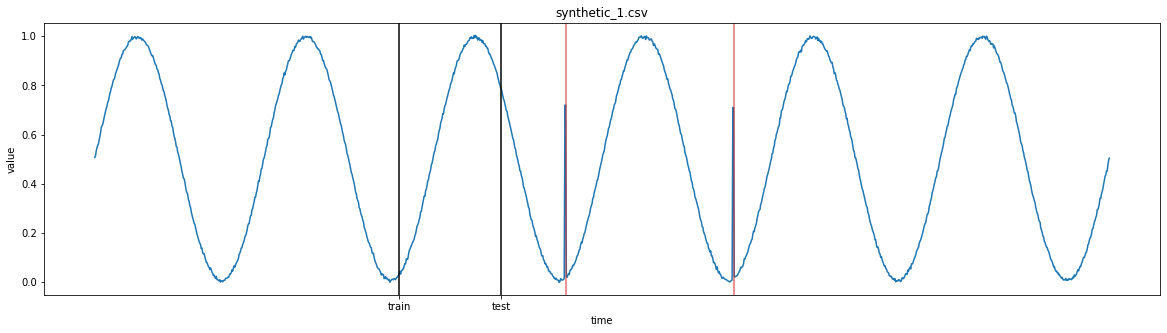

In [ ]:
# Create a trainer object for training
trainer = Trainer(args, full_len, trn_len, dev_len, tst_len, full_loader, trn_loader, dev_loader, tst_loader)

# Train
# trainer output: best checkpoint, version(the order of executions)
best_result, version = trainer.fit()

# Test
# load the checkpoint to be tested
data_path = args.root_path + args.data_name
model_path = f'./saved_model/{args.experiment_name}/{data_path[3:-4]}/version-{version}/checkpoints/epoch-{best_result}.pt'
ckpt = torch.load(model_path)

# compute anomaly score, detect anomalies, compute performance measures, and plot the result
trainer.test(ckpt, version)

---